In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import verde as vd
import harmonica as hm
import boule as bl
import ensaio
import pygmt
import pyproj
import choclo

import warnings
warnings.filterwarnings("ignore")

In [2]:
# projection = pyproj.Proj(proj='utm', ellps='WGS84', zone=24, south=True)

# region = (-41.5572222222, -41.2802777778, -20.8008333333, -20.5533333333)
# # Pad the region for slicing the grids
# region_pad = vd.pad_region(region, pad=0.02)
# grid = vd.grid_coordinates(region, spacing= 2 / 3600)
# grid

In [3]:
# easting, northing = projection(grid[0], grid[1])
# upward = easting*0 - 500

In [4]:
# coordinates = (easting.ravel(), northing.ravel(), upward.ravel())

In [5]:
obs_distance = 1500.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 10000, 0, 10000],  # µm
    spacing=200,  # µm
    extra_coords=obs_distance,
)

easting, northing, upward = coordinates

In [6]:
# Define a single point mass located 10 meters below the zero height
easting_m, northing_m, upward_m = np.mean(coordinates[0]), np.mean(coordinates[1]), 3000
# mass = 1e10  # mass of the source in kg

rho = 5000.0 # densidade em kg/m3
R = 1000.0 # raio em m
mass = rho*4/3*np.pi*R**3 # massa da esfera de densidade rho e raio R em kg

# Compute the upward compont of the gravity acceleration the point mass
# generates on this observation point (in SI units)
g_u = choclo.point.gravity_u(
   easting, northing, upward, easting_m, northing_m, upward_m, mass
)

In [7]:
data = vd.make_xarray_grid(coordinates, g_u*1.0e5, data_names=["bz"], dims=("northing", "easting"), extra_coords_names='upward')
data.easting.attrs = {"units": "m"}
data.northing.attrs = {"units": "m"}
data.bz.attrs = {"long_name": "vertical gravity field", "units": "mGal"}
data.bz.values.max()

62.12720547512401

In [8]:
# Define a single point mass located 10 meters below the zero height
easting_m_regional, northing_m_regional, upward_m_regional = 0, 0, 10000
# mass = 1e10  # mass of the source in kg

rho = -5000.0 # densidade em kg/m3
R = 2000.0 # raio em m
mass = rho*4/3*np.pi*R**3 # massa da esfera de densidade rho e raio R em kg

# Compute the upward compont of the gravity acceleration the point mass
# generates on this observation point (in SI units)
g_u_regional = choclo.point.gravity_u(
   easting, northing, upward, easting_m_regional, northing_m_regional, upward_m_regional, mass
)

data = data.assign(regional_trend=xr.DataArray(g_u_regional*1.0e5, coords=data.coords))
data = data.assign(gravity_bouguer_mgal=xr.DataArray(data.bz.values + data.regional_trend.values, coords=data.coords))
data = data.assign(upward_2=xr.DataArray(data.upward.values, coords=data.coords))
data

<xarray.Dataset>
Dimensions:               (northing: 51, easting: 51)
Coordinates:
  * easting               (easting) float64 0.0 200.0 400.0 ... 9.8e+03 1e+04
  * northing              (northing) float64 0.0 200.0 400.0 ... 9.8e+03 1e+04
    upward                (northing, easting) float64 1.5e+03 ... 1.5e+03
Data variables:
    bz                    (northing, easting) float64 0.5552 0.5879 ... 0.5552
    regional_trend        (northing, easting) float64 -15.48 -15.47 ... -2.116
    gravity_bouguer_mgal  (northing, easting) float64 -14.92 -14.88 ... -1.561
    upward_2              (northing, easting) float64 1.5e+03 ... 1.5e+03

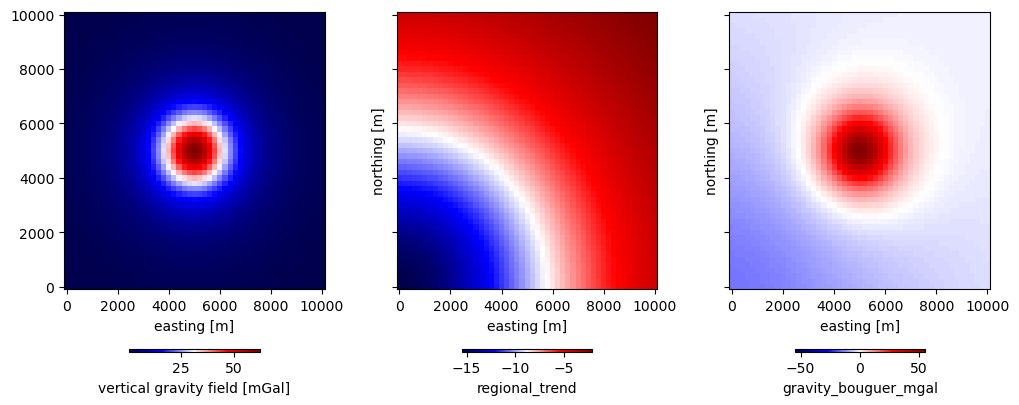

In [9]:
# data.regional_trend.plot.pcolormesh(cmap="seismic")

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["bz", "regional_trend", "gravity_bouguer_mgal"], axes.ravel()):
    if field == "TG":
        cmap = "plasma"
    else:
        cmap="seismic"
    data[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0].set_ylabel(None)
# axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

In [10]:
# data = data.assign(bouguer_derivative_northing=hm.derivative_easting(data.gravity_bouguer_mgal, order=1, method='finite-diff'))
# data = data.assign(bouguer_derivative_easting=hm.derivative_northing(data.gravity_bouguer_mgal, order=1, method='finite-diff'))
# data = data.assign(bouguer_derivative_upward=hm.derivative_upward(data.gravity_bouguer_mgal, order=1))

# data = data.assign(TG=np.sqrt(data.bouguer_derivative_easting**2  +
#                                                 data.bouguer_derivative_northing**2 +
#                                                 data.bouguer_derivative_upward**2
#                                                ))
# data


def data_gradients(data, spacing=200):
    """
    Add the derivatives and total gradient amplitude
    """
    dx = data.differentiate("easting")
    dy = data.differentiate("northing")
    # spacing = np.mean([np.abs(data.easting[1] - data.easting[0]), np.abs(data.northing[1] - data.northing[0])])
    # Need to set the exact same coordinates because the xrft inverse transform
    # creates slightly different ones because of round-off errors.

    
    data_up = hm.upward_continuation(data, spacing).assign_coords(
        dict(longitude=data.easting, latitude=data.northing)
    )

    data_down = hm.upward_continuation(data, -spacing).assign_coords(
        dict(longitude=data.easting, latitude=data.northing)
    )

    # Forward difference only to avoid downward continuation.
    dz = (data_up - data_down) / (2 * spacing)
    tga = np.sqrt(dx**2 + dy**2 + dz**2)
    tga.attrs = {"long_name": "total gradient amplitude", "units": "mGal/m"}
    dx.attrs = {"long_name": "derivative_easting", "units": "mGal/m"}
    dy.attrs = {"long_name": "derivative_northing", "units": "mGal/m"}
    dz.attrs = {"long_name": "derivative_upward", "units": "mGal/m"}
    return xr.Dataset({"tga": tga, "x_deriv": dx, "y_deriv": dy, "z_deriv": dz})




data = data.assign(data_gradients(data.gravity_bouguer_mgal, spacing=10))
data

<xarray.Dataset>
Dimensions:               (northing: 51, easting: 51)
Coordinates:
  * easting               (easting) float64 0.0 200.0 400.0 ... 9.8e+03 1e+04
  * northing              (northing) float64 0.0 200.0 400.0 ... 9.8e+03 1e+04
    upward                (northing, easting) float64 1.5e+03 ... 1.5e+03
    longitude             (easting) float64 0.0 200.0 400.0 ... 9.8e+03 1e+04
    latitude              (northing) float64 0.0 200.0 400.0 ... 9.8e+03 1e+04
Data variables:
    bz                    (northing, easting) float64 0.5552 0.5879 ... 0.5552
    regional_trend        (northing, easting) float64 -15.48 -15.47 ... -2.116
    gravity_bouguer_mgal  (northing, easting) float64 -14.92 -14.88 ... -1.561
    upward_2              (northing, easting) float64 1.5e+03 ... 1.5e+03
    tga                   (northing, easting) float64 0.08239 ... 0.02349
    x_deriv               (northing, easting) float64 0.0002281 ... 7.126e-05
    y_deriv               (northing, easting) float64 0.0002281 ... 7.126e-05
    z_deriv               (northing, easting) float64 0.08239 ... -0.02349

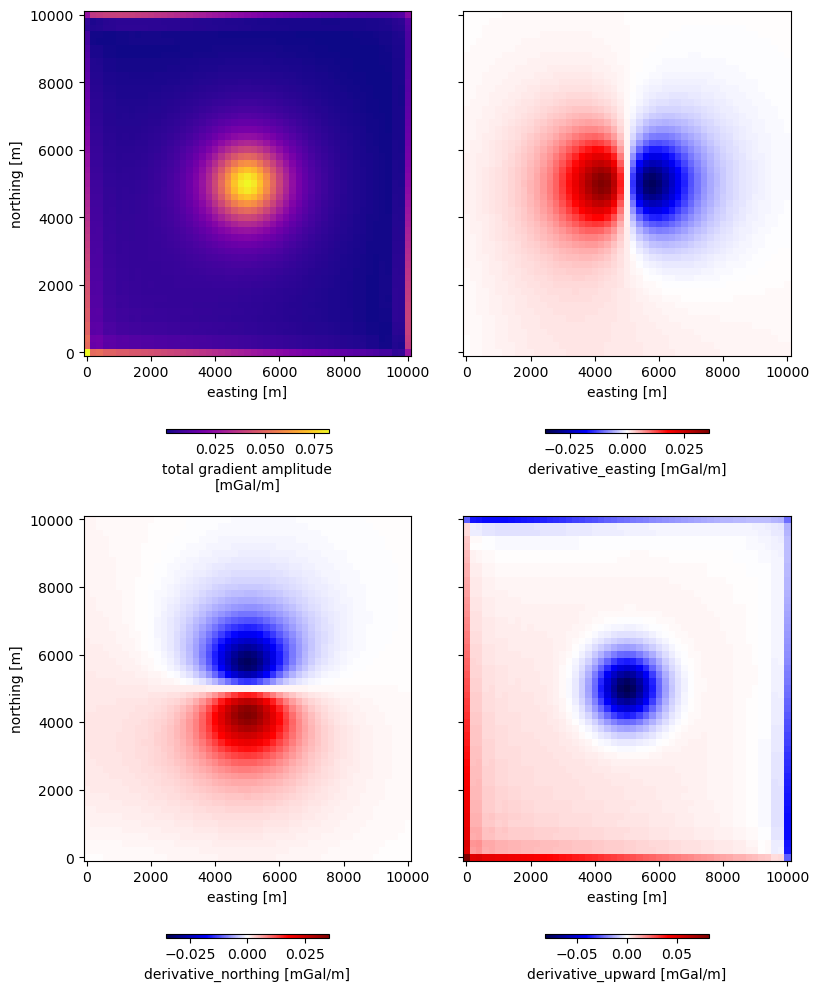

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

In [12]:
data_table = vd.grid_to_table(data)
data_table.x_deriv.max()

0.03569570268018202

# Equivalent Layer Inversion

In [115]:
# import numba

# @numba.jit(nopython=True, parallel=True)
# def _matriz_sensibilidade(x_i, y_i, z_i, x_j, y_j, z_j):
#     gamma = 6.67e-11 # constante de gravitação universal, mudei o nome para não confundir com a matriz G
#     cte   = 2*np.pi*gamma *10**5 # convertitido para mGal
#     G = np.zeros( (len(x_i), len(x_j)) ) # matriz n x m
#     Gz = np.zeros( (len(x_i), len(x_j)) ) # matriz n x m
#     Gx = np.zeros( (len(x_i), len(x_j)) ) # matriz n x m
#     Gy = np.zeros( (len(x_i), len(x_j)) ) # matriz n x m
    
    
#     for j in numba.prange(len(x_j)):
#         for i in range(len(x_i)):
            
#             delta_x = x_i[i] - x_j[j]
#             delta_y = y_i[i] - y_j[j]
#             delta_z = z_i[i] - z_j[j]
#             r2 = delta_x**2 + delta_y**2 + delta_z**2

#             # cada ponto obs tem q considerar o efeito de cada túnel
#             gz_i_j  = cte*(delta_z/r2)
#             gzz_i_j = cte*(1/r2-2*delta_z**2/r2**2) 

#             gzx_i_j  = cte*(-2*delta_x*delta_z**2/r2**2)
#             gzy_i_j  = cte*(-2*delta_y*delta_z**2/r2**2)
            
#             G[i,j]  = gz_i_j  
#             Gz[i,j] = gzz_i_j
#             Gx[i,j] = gzx_i_j
#             Gy[i,j] = gzy_i_j
            
#     return G, Gz, Gy, Gx
    
    


# def eq_la_bzz(data, extra_coord=0, damping=1.0e-1):
#     x_i, y_i, z_i = data.easting.values, data.northing.values, data.upward_2.values
#     # x_j, y_j = grid[0].ravel(), grid[1].ravel()
#     # z_j = x_j*0 + extra_coord

#     x_j, y_j, z_j = data.easting.values, data.northing.values, data.upward_2.values*0+extra_coord

#     G, Gz, Gy, Gx = _matriz_sensibilidade(x_i, y_i, z_i, x_j, y_j, z_j)

    
#     mz = (np.linalg.inv(Gz.T@Gz)+damping*np.identity(np.shape(Gz)[0]))@(Gz.T@data.z_deriv)
#     # mz = np.linalg.inv(Gz.T@Gz)@(Gz.T@data.z_deriv.values)
#     predicted_z_derivative = Gz@mz

#     mx= (np.linalg.inv(Gx.T@Gx))@(Gx.T@data.x_deriv.values)
#     predicted_x_derivative = Gx@mx

#     my = (np.linalg.inv(Gy.T@Gy))@(Gy.T@data.y_deriv.values)
#     predicted_y_derivative = Gy@my

#     m = (np.linalg.inv(G.T@G)+damping*np.identity(np.shape(G)[0]))@(G.T@data.gravity_bouguer_mgal)
#     # m = (np.linalg.inv(G.T@G))@(G.T@data.gravity_bouguer_mgal.values)
#     predicted_bouguer      = G@mz


#     for i in range(20):
#         print(f'{mz[i]:.3e}, {my[i]:.3e}, {mx[i]:.3e}, {m[i]:.3e}')
    
#     return predicted_z_derivative, predicted_y_derivative, predicted_x_derivative, predicted_bouguer




######################################################################################################


import numba
import choclo
import scipy


from numba import jit

@jit(nopython=True)
def kernel_uuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along upward-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.


    """
    return 9 * (upward_p - upward_q) / distance**5 - 15 * (upward_p - upward_q)**3 / distance**7



@jit(nopython=True)
def kernel_euu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (easting_p - easting_q) / distance**5 
            - 15 * (easting_p - easting_q) * (upward_p - upward_q)**2 / distance**7)


@jit(nopython=True)
def kernel_nuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (northing_p - northing_q) / distance**5 
            - 15 * (northing_p - northing_q) * (upward_p - upward_q)**2 / distance**7)


def z_deriv_inversion(data, extra_coord=0):
    
    data = data.to_xarray()
    
    n_data = len(data['z_deriv']) #table.shape[0]
    n_params = len(data.easting.values)
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['z_deriv']).ravel() 
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.easting.values ,
        data.northing.values ,
        data.upward_2.values ,
        data.easting.values ,
        data.northing.values  ,
        data.northing.values*0+extra_coord ,
        A,
    )

    hessian = A.T @ A
    neg_gradient = A.T @ d
    masses = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ masses
    
    # masses = np.reshape(masses, (int(n_params/3), 3) )
    return masses, residuals, A @ masses


@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = 2*np.pi*choclo.constants.VACUUM_MAGNETIC_PERMEABILITY *1.0E5 # convertido em mGals

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )


# These are the second derivatives of 1/r
            jacobian[i, j] = constant*kernel_euu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            ) + constant*kernel_nuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            ) + constant*kernel_uuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            
            # # These are the second derivatives of 1/r
            # jacobian[i, j*3] = constant*kernel_euu(
            #     easting_p  =e[i],
            #     northing_p =n[i],
            #     upward_p   =u[i],
            #     easting_q  =de[j],
            #     northing_q =dn[j],
            #     upward_q   =du[j],
            #     distance   =distance,
            # )
            # jacobian[i, j*3+1] = constant*kernel_nuu(
            #     easting_p  =e[i],
            #     northing_p =n[i],
            #     upward_p   =u[i],
            #     easting_q  =de[j],
            #     northing_q =dn[j],
            #     upward_q   =du[j],
            #     distance=distance,
            # )
            # jacobian[i, j*3+2] = constant*kernel_uuu(
            #     easting_p  =e[i],
            #     northing_p =n[i],
            #     upward_p   =u[i],
            #     easting_q  =de[j],
            #     northing_q =dn[j],
            #     upward_q   =du[j],
            #     distance   =distance,
            # )




def bz_inversion(data, extra_coord=0):
    
    data = data.to_xarray()
    
    n_data = len(data['gravity_bouguer_mgal']) #table.shape[0]
    n_params = len(data.easting.values)
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['gravity_bouguer_mgal']).ravel() 
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast_2(
        data.easting.values ,
        data.northing.values ,
        data.upward_2.values ,
        data.easting.values ,
        data.northing.values  ,
        data.northing.values*0+extra_coord ,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    masses = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ masses
    
 
    return A, A @ masses, masses

# @numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast_2(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = 2*np.pi*choclo.constants.VACUUM_MAGNETIC_PERMEABILITY *1.0E5 # convertido em mGals

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # These are the second derivatives of 1/r
            jacobian[i, j] = constant * choclo.point.gravity_eu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                mass=1
                # distance   =distance,
            ) + constant * choclo.point.gravity_nu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                mass=1,
                # distance=distance, 
            ) + constant * choclo.point.gravity_uu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                mass = 1
                # distance   =distance,
            )

In [119]:
# predicted_z_derivative, predicted_y_derivative, predicted_x_derivative, predicted_bouguer = eq_la_bzz(data_table, extra_coord=1200)
teste, residuals, z_teste = z_deriv_inversion(data_table, extra_coord=1000)

A, bouguer, masses = bz_inversion(data_table, extra_coord=1000)

In [128]:
predicted_bouguer=bouguer
predicted_z_derivative = z_teste

In [129]:
data_table = data_table.assign(predicted_bouguer=predicted_bouguer.ravel())
data_table = data_table.assign(predicted_z_derivative=predicted_z_derivative.ravel())
# data_table = data_table.assign(predicted_bouguer=predicted_bouguer.ravel())
# data_table = data_table.assign(predicted_bouguer=predicted_bouguer.ravel())

In [130]:
len(predicted_bouguer)

2601

In [131]:
data_table

,northing,easting,bz,regional_trend,gravity_bouguer_mgal,upward_2,tga,x_deriv,y_deriv,z_deriv,predicted_bouguer,predicted_z_derivative
0,0.0,0.0,0.555170,-15.478058,-14.922888,1500.0,0.082395,0.000228,0.000228,0.082394,-14.922888,0.082394
1,0.0,200.0,0.587940,-15.465213,-14.877273,1500.0,0.050981,0.000297,0.000245,0.050979,-14.877273,0.050979
2,0.0,400.0,0.622520,-15.426785,-14.804266,1500.0,0.052157,0.000433,0.000263,0.052154,-14.804266,0.052154
3,0.0,600.0,0.658926,-15.363091,-14.704164,1500.0,0.048760,0.000567,0.000283,0.048756,-14.704164,0.048756
4,0.0,800.0,0.697158,-15.274652,-14.577494,1500.0,0.048868,0.000698,0.000304,0.048862,-14.577494,0.048862
...,...,...,...,...,...,...,...,...,...,...,...,...
2596,10000.0,9200.0,0.697158,-2.308620,-1.611462,1500.0,0.010629,0.000052,0.000031,-0.010629,-1.611462,-0.010629
2597,10000.0,9400.0,0.658926,-2.259366,-1.600440,1500.0,0.010552,0.000058,0.000043,-0.010552,-1.600440,-0.010552
2598,10000.0,9600.0,0.622520,-2.210836,-1.588316,1500.0,0.011665,0.000063,0.000054,-0.011665,-1.588316,-0.011665
2599,10000.0,9800.0,0.587940,-2.163050,-1.575110,1500.0,0.012449,0.000069,0.000063,-0.012448,-1.575110,-0.012448


In [132]:
masses

array([-3.64164277e+19,  1.07071884e+19, -2.54470198e+19, ...,
       -2.69791712e+17, -1.40247548e+17, -4.41832571e+17])

In [133]:
teste

array([-1.49528263e+09,  3.80158680e+08, -1.06402378e+09, ...,
        1.09689726e+08,  2.68430851e+07,  2.26957390e+08])